# Imaging and point source simulation testing
Need to make some useful python code that simulates an FRB at a prticular location on the sky. A little TMS is needed here https://link.springer.com/book/10.1007/978-3-319-44431-4

In [3]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
sys.path.append('/Users/ban115/bolton/craft/code/python') # for calc11

import calc11
import numpy as np
from scipy import constants

%matplotlib inline


In [4]:
fc = 1.32 # center frequency GHz
bw = 0.288 # bandwidth GHz
Nd = 1024 # number of DM trials
Nt = 256 # time block size
Nb = 4 # bytes per complex sample. 4 = fp16 complex
Tint = 1e-3 # integration time - seconds
Nchan= 288
Npol = 2 # input number of polarisations
Npix = 256
ignore_ant = ['ak31','ak32','ak33','ak34','ak35','ak36']


f1 = fc - bw/2.
f2 = fc + bw/2.
chanbw = 1e-3
lam1 = 3e8/f1/1e9
lam2 = 3e8/f2/1e9
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = constants.c / (freqs*1e9)
print(lam1, lam2, lambdas.min(), lambdas.max(), freqs.min(), freqs.max())

0.255102040816 0.204918032787 0.20491623923444977 0.25492555952380946 1.1760000000000002 1.463


In [5]:
cfile = calc11.ResultsFile('SB6637neweop_alltell.im')
mjd = cfile.scans[0].first_mjd
p = cfile.scans[0].eval_src0_poly(mjd)
telnames = [t for t in cfile.telnames if t.lower() not in ignore_ant]
print('Got', len(telnames), 'antennas')

Got 30 antennas


Vsmall AK01 AK03 2.0069104223512113
Usmall AK01 AK04 5.2652132348157465
Vsmall AK04 AK15 2.5086510279215872
Usmall AK05 AK08 7.827149305026978
Usmall AK05 AK10 3.0604471219703555
Usmall AK05 AK14 2.0479273181408644
Vsmall AK05 AK15 8.244422250892967
Usmall AK05 AK18 3.150120552862063
Usmall AK05 AK23 1.0489445968996733
Usmall AK08 AK10 4.766702183056623
Usmall AK08 AK14 9.875076623167843
Usmall AK08 AK18 4.677028752164915
Usmall AK08 AK23 6.778204708127305
Vsmall AK09 AK20 2.078002214897424
Usmall AK10 AK14 5.10837444011122
Usmall AK10 AK18 0.08967343089170754
Usmall AK10 AK23 2.011502525070682
Usmall AK14 AK18 5.198047871002927
Usmall AK14 AK23 3.0968719150405377
Usmall AK18 AK23 2.1011759559623897


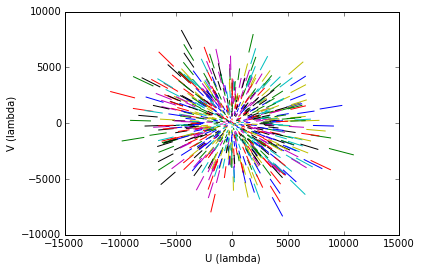

In [6]:
figure()
all_rlam = []
uvw = []
for ia1, a1 in enumerate(telnames):
    for ia2, a2 in enumerate(telnames[ia1+1:]):
        #u = [val[a1]['U (m)'] - val[a2]['U (m)'] for val in values]
        #v = [val[a1]['V (m)'] - val[a2]['V (m)'] for val in values]
        #w = [val[a1]['W (m)'] - val[a2]['W (m)'] for val in values]
        u = p[a1]['U (m)'] - p[a2]['U (m)']
        v = p[a1]['V (m)'] - p[a2]['V (m)']
        w = p[a1]['W (m)'] - p[a2]['W (m)']
        if abs(v) < 10:
            print('Vsmall', a1, a2, abs(v))
            
        if abs(u) < 10:
            print('Usmall', a1, a2, abs(u))
            
        uvw.append((u,v,w))
        #print a1, a2, u, v, w
        ulam1, vlam1, wlam1 = u/lam1, v/lam1, w/lam1
        ulam2, vlam2, wlam2 = u/lam2, v/lam2, w/lam2
        r = np.sqrt(u*u + v*v)
        rlam1 = r/lam1
        rlam2 = r/lam2
        all_rlam.append((rlam1 - rlam2))
        plot([ulam1, ulam2], [vlam1, vlam2])
        plot([-ulam1, -ulam2], [-vlam1, -vlam2])

        
xlabel('U (lambda)')
ylabel('V (lambda)')
uvw = np.array(uvw)
uvwlam1 = uvw/lam1
uvwlam2 = uvw/lam2

In [14]:
assert(lam2 < lam1)

urange = uvwlam2[:, 0].max() - uvwlam2[:, 0].min()
vrange = uvwlam2[:, 1].max() - uvwlam2[:, 1].min()
lres = np.degrees(1.0/urange)*3600.
mres = np.degrees(1.0/vrange)*3600.
ucell = urange/float(Npix)
vcell = vrange/float(Npix)
lsize = np.degrees(1./ucell)
msize = np.degrees(1./vcell)
cellsize = min(ucell, vcell)

print('UV range={:0.1f}x{:0.1f} lambda = {:0.1f}x{:0.1f} arcsec FoV: {:0.2f}x{:0.2f} deg'.format(urange, vrange, lres, mres,lsize, msize))

UV range=19691.9x14483.3 lambda = 10.5x14.2 arcsec FoV: 0.74x1.01 deg


In [15]:
def pointsim(amp, lm, p, telnames, freqs, noiseamp=0):
    nant = len(telnames)
    nbl = nant*nant-1//2
    nf = len(freqs)
    lambdas = constants.c / (freqs*1e9)
    l, m = lm
    d = {}
    for ia1, a1 in enumerate(telnames):
        for ia2, a2 in enumerate(telnames[ia1+1:]):
            # UVW im meters
            u_m = p[a1]['U (m)'] - p[a2]['U (m)']
            v_m = p[a1]['V (m)'] - p[a2]['V (m)']
            w_m = p[a1]['W (m)'] - p[a2]['W (m)']
            
            # uvw in wavelengths - these are vectors becuase lambdas is a vector
            u = u_m/lambdas
            v = v_m/lambdas
            w = w_m/lambdas
            
            # TMS equation 3.7 - don't include 1/sqrt(1 - l*l - m*m) denomiator term for point sources
            vis = amp*np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1)))
            if noiseamp > 0:
                vishape = vis.shape
                noise = noiseamp*(np.random.randn(*vishape) + 1j*np.random.randn(*vishape))
                vis += noise
            
            d[(a1, a2)] = vis
            
    return d
    

In [16]:
print(ucell, vcell)

76.92155221819027 56.575455393967715


In [17]:
def grid(p, uvdata, lambdas, ucell, vcell, Npix, weights=False):
    g = np.zeros((Npix, Npix), dtype=np.complex64)
    for (a1, a2) in list(uvdata.keys()):
         # UVW im meters
        u_m = p[a1]['U (m)'] - p[a2]['U (m)']
        v_m = p[a1]['V (m)'] - p[a2]['V (m)']
        w_m = p[a1]['W (m)'] - p[a2]['W (m)']
        
        # uvw in wavelengths - these are vectors becuase lambdas is a vector
        ulam = u_m/lambdas
        vlam = v_m/lambdas
        wlam = u_m/lambdas

        upix = np.round(ulam/ucell + float(Npix)/2.).astype(int) 
        vpix = np.round(vlam/vcell + float(Npix)/2.).astype(int)       

        assert np.all(upix >= 0), "invalid upix{}".format(upix)
        assert np.all(upix < Npix)
        assert np.all(vpix >=0)
        assert np.all(vpix < Npix), 'invalid vpix ibl={}{}{}'.format(a1,a2, vpix)

        # If upix or vpix contain multiple N identical indices, the it only increments by 1, not by 
        # N as expected. So we need to unroll the loop
        #g[vpix,upix] += 1

        if weights:
            for vp,up in zip(vpix, upix):
                g[ vp,  up] += 1
                g[-vp, -up] += 1
        else:
            for ichan, (vp, up) in enumerate(zip(vpix, upix)):
                v = uvdata[(a1,a2)][ichan]
                g[ vp,  up] += v
                g[-vp, -up] += np.conj(v)

    return g

def image_fft(g):
    '''
    Do the complex-to-complex imaging FFT with the correct shifts and correct inverse thingy
    If g.shape = (Npix, Npix) then we assume the center of the UV plane is at
    Npix/2, Npix/2 = DC
    '''
    # The old version was incorrect!
    #cimg = np.fft.fftshift(np.fft.ifft2(g)).astype(np.complex64)
    
    cimg = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(g))).astype(np.complex64)
    return cimg/np.prod(cimg.shape)
            

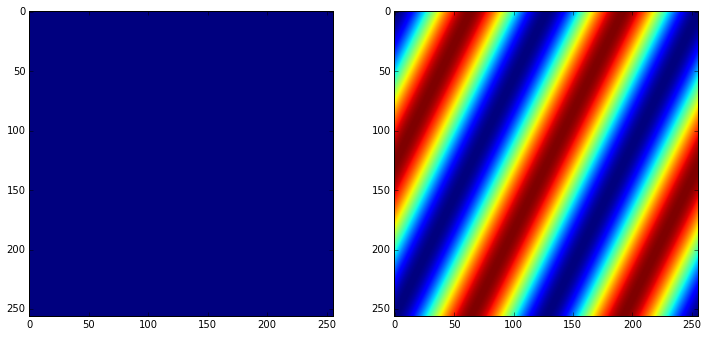

In [18]:
# Check DC is in the center of the UV plane
g1 = np.zeros((Npix, Npix), dtype=np.complex64)
g2 = g1.copy()
g1[Npix/2, Npix/2] = 1
g2[Npix/2+1, Npix/2+2] = 1

img1 = image_fft(g1)
img2 = image_fft(g2) # should be slow bands

fig, axs = subplots(1,2, figsize=(12,6))
axs[0].imshow(img1.real)
axs[1].imshow(img2.real)

In [19]:
uvdata = pointsim(1,(np.radians(-1*0.1), np.radians(3*0.1)), p, telnames, freqs, noiseamp=0)
g = grid(p, uvdata, lambdas, vcell, vcell, Npix, weights=False)
extents = (-Npix/2., Npix/2., -Npix/2., Npix/2.)
imshow(np.abs(g), aspect='auto', origin='lower', extent=extents)
xlabel('U')
ylabel('V')

AssertionError: invalid upix[ 14  13  13  13  13  13  13  13  13  13  13  12  12  12  12  12  12  12
  12  12  12  12  11  11  11  11  11  11  11  11  11  11  10  10  10  10
  10  10  10  10  10  10   9   9   9   9   9   9   9   9   9   9   9   8
   8   8   8   8   8   8   8   8   8   7   7   7   7   7   7   7   7   7
   7   6   6   6   6   6   6   6   6   6   6   5   5   5   5   5   5   5
   5   5   5   5   4   4   4   4   4   4   4   4   4   4   3   3   3   3
   3   3   3   3   3   3   2   2   2   2   2   2   2   2   2   2   1   1
   1   1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0   0
   0  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -2  -2  -2  -2  -2  -2  -2
  -2  -2  -2  -2  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -4  -4  -4  -4
  -4  -4  -4  -4  -4  -4  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -6  -6
  -6  -6  -6  -6  -6  -6  -6  -6  -6  -7  -7  -7  -7  -7  -7  -7  -7  -7
  -7  -8  -8  -8  -8  -8  -8  -8  -8  -8  -8  -9  -9  -9  -9  -9  -9  -9
  -9  -9  -9  -9 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -11 -11 -11 -11
 -11 -11 -11 -11 -11 -11 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -13 -13
 -13 -13 -13 -13 -13 -13 -13 -13 -13 -14 -14 -14 -14 -14 -14 -14 -14 -14]

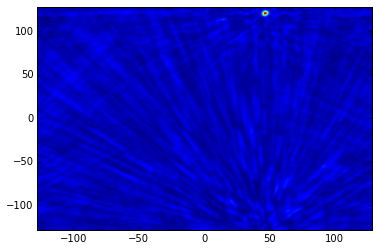

In [13]:
cimg = image_fft(g)
imshow(cimg.real, aspect='auto', origin='lower', extent=extents)
g.tofile('nonoise.grid')
cimg.tofile('nonoise.image')

In [509]:
print('abs', np.abs(cimg).max(), 'real', abs(cimg.real).max(), 'imag', abs(cimg.imag).max())

abs 2.069378137588501 real 2.069378137588501 imag 9.771049359972705e-15


# How about with noise - does that work?

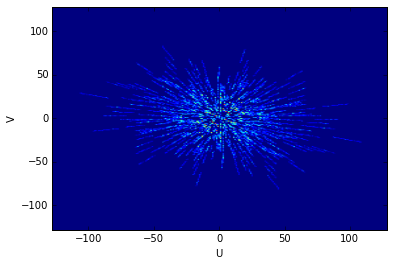

In [12]:
uvdata = pointsim(0.04,(np.radians(-1*0.1), np.radians(3*0.1)), p, telnames, freqs,noiseamp=1)
g = grid(p, uvdata, lambdas, vcell, vcell, Npix, weights=False)
imshow(np.abs(g), aspect='auto', origin='lower', extent=extents)
xlabel('U')
ylabel('V')

abs 0.081555665 real 0.081555665 imag 2.3265202e-16 6.004086e-13 0.011138868
S/N 7.3217196 Improvement 353.94914889006304


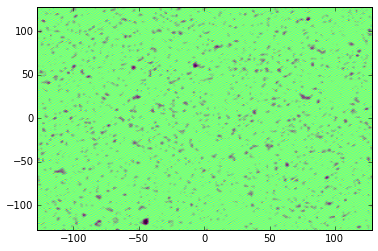

In [13]:
cimg = np.fft.fftshift(np.fft.ifft2(g)).astype(np.complex64)
imgstd = np.real(cimg).std()
imshow(np.real(cimg), aspect='auto', origin='lower', extent=extents, vmin=-5*imgstd, vmax=5*imgstd)
print('abs', np.abs(cimg).max(), 'real', np.real(cimg).max(), 'imag', np.imag(cimg).max(), np.real(cimg).mean(), imgstd)
Nant = len(telnames)
Nbl = Nant*(Nant-1)/2
print('S/N', np.real(cimg).max()/imgstd, 'Improvement', np.sqrt(Nchan*Nbl))

g.tofile('withnoise.grid')
cimg.tofile('withnoise.image')

# How do you do the gridding with  a complex-to-real FFT?
Because wrapping my head around the indexing would be useful. By the end of wednesday - I think this was working.


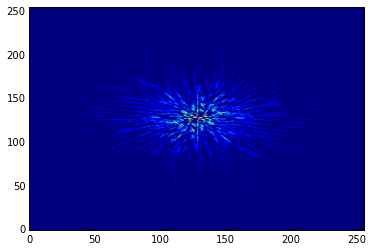

In [14]:
smalltelnames = telnames
#smalltelnames = ['AK05','AK14','AK15',]
#smalltelnames = ['AK05','AK14']
hlambdas = lambdas
uvdata = pointsim(1,(np.radians(-1*0.1), np.radians(3*0.1)), p, smalltelnames, freqs)
g = grid(p, uvdata, hlambdas, vcell, vcell, Npix, weights=False)
imshow(abs(g), aspect='auto', origin='lower')

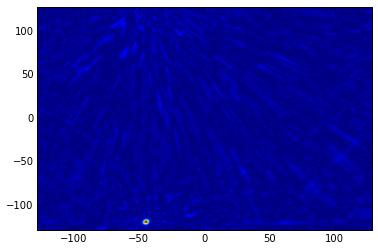

In [15]:
cimg = np.fft.fftshift(np.fft.ifft2(g))
imshow(np.abs(cimg), aspect='auto', origin='lower', extent=extents)

(256, 129)


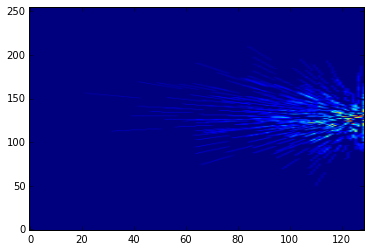

In [16]:
uv2 = np.fft.rfft2(np.fft.ifftshift(np.real(cimg)))
print(uv2.shape)
imshow(abs(uv2), aspect='auto', origin='lower')

Error in 2-sided vs hermetian 2.646214673973929e-15


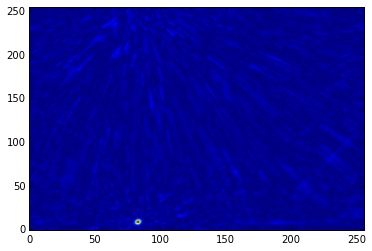

In [17]:
imgagain = np.fft.fftshift(np.fft.irfft2(uv2))
imshow(abs(imgagain), aspect='auto', origin='lower')
print('Error in 2-sided vs hermetian', abs(imgagain - cimg).max()/abs(cimg).max())

In [18]:
def hermetian_grid(p, uvdata, lambdas, ucell, vcell, Npix, weights=False):
    nhalf = Npix//2 + 1
    g = np.zeros((Npix, nhalf), dtype=np.complex64)
    for (a1, a2) in list(uvdata.keys()):
         # UVW im meters
        u_m = p[a1]['U (m)'] - p[a2]['U (m)']
        v_m = p[a1]['V (m)'] - p[a2]['V (m)']
        w_m = p[a1]['W (m)'] - p[a2]['W (m)']
        
        # uvw in wavelengths - these are vectors becuase lambdas is a vector
        ulam = u_m/lambdas
        vlam = v_m/lambdas
        wlam = u_m/lambdas

        upix = np.round(ulam/ucell + Npix/2).astype(int) 
        vpix = np.round(vlam/vcell + Npix/2).astype(int)       

        assert np.all(upix >= 0), "invalid upix{}".format(upix)
        assert np.all(upix < Npix)
        assert np.all(vpix >=0)
        assert np.all(vpix < Npix), 'invalid vpix ibl={}{}{}'.format(a1,a2, vpix)

        # If upix or vpix contain multiple N identical indices, the it only increments by 1, not by 
        # N as expected. So we need to unroll the loop
        #g[vpix,upix] += 1

        if weights:
            for vp,up in zip(vpix, upix):
                if up >= nhalf: # flip around Y axis:
                    up = Npix - up
                g[vp, up] += 1
        else:
            for ichan, (vp, up) in enumerate(zip(vpix, upix)):
                v = uvdata[(a1,a2)][ichan]
                if up < nhalf-1:
                    g[vp, up] += (v)
                elif up == nhalf-1:
                    g[vp, up] += v
                    g[-vp, Npix-up] += np.conj(v)
                else:
                    g[-vp, Npix - up] += np.conj(v)


    return g
            

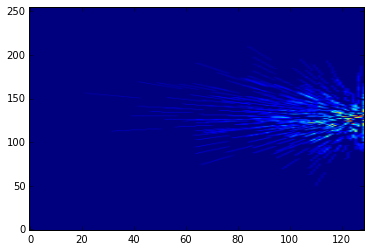

In [19]:
hg = hermetian_grid(p, uvdata, hlambdas, vcell, vcell, Npix, weights=False)
imshow(abs(hg), aspect='auto', origin='lower')

This looks very close in amplitude, but there's a problem with the phases. this isn't a high priority for the moment, but we can look into it later. I wonder whether we have to change the conjugation using some other logic.

1.416105131736036e-15 3.553531380629256e-08


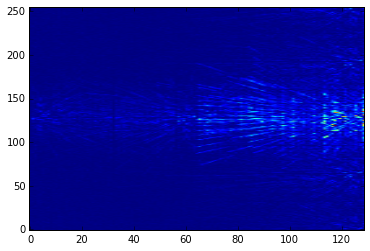

In [20]:
imshow(abs(hg - uv2), aspect='auto', origin='lower')
print(abs(hg - uv2).max()/abs(uv2).max(),(abs(hg) - abs(uv2)).max()/abs(uv2).max())

(100, 170)

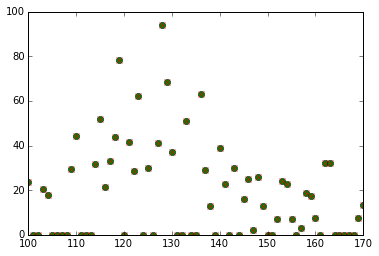

In [21]:
uslice=97
plot(abs(hg[:,uslice]),'go')
plot(abs(uv2[:,uslice]),'rx')
xlim(100,170)


(125, 150)

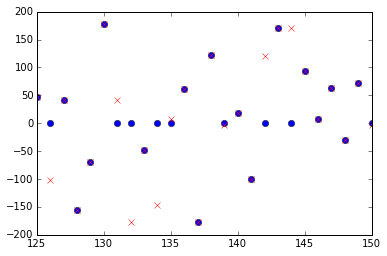

In [22]:
mask = abs(hg[:,-1]) > 0.1
plot(np.angle(hg[:,uslice], deg=True),'o')
plot(np.angle(uv2[:,uslice], deg=True),'rx')
xlim(125,150)

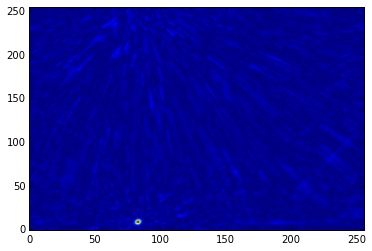

In [23]:
hgimg = np.fft.fftshift(np.fft.irfft2(hg))
uv2img = np.fft.fftshift(np.fft.irfft2(uv2))
imshow(abs(hgimg), aspect='auto', origin='lower')


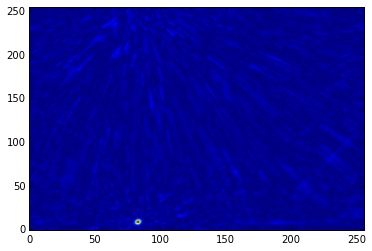

In [24]:
imshow(abs(uv2img), aspect='auto', origin='lower')

# Simple testing 
Below is some simple stuff to try to wrap my head around what's happening. Grr

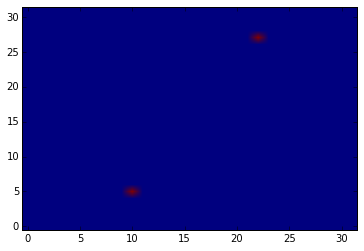

In [25]:
N=32
x = np.zeros((N,N), dtype=complex)
v = 1+1j
vp, up = 5,10
x[vp,up] = v
x[-vp,-up] = np.conj(v)
extents=(-N/2,N/2, -N/2,N/2)
extents=None
imshow(abs(x), aspect='auto', origin='lower', extent=extents)

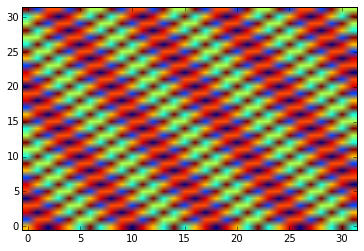

In [26]:
ximg = np.fft.fftshift(np.fft.ifft2(x))
imshow(abs(ximg), origin='lower', aspect='auto', extent=extents)

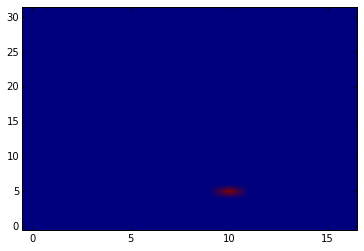

In [27]:
xback = np.fft.rfft2(np.fft.ifftshift(np.real(ximg)))
imshow(abs(xback),origin='lower', aspect='auto')

In [28]:
xback[vp,up]

(1.0000000000000013+0.9999999999999984j)

# How do you grid two DMs with a complex-to-complex FFT?
From John Bunton:
>    Hi Kieth,
>
>    I know the trick for Real->Complex.  SO...
>
>    For Complex to Real the data must be Hermitian.
>    So we have
>    Hermitian ->FFT -> Real
>    And we have
>    Anti Hermitian ->FFT -> Imaginary.   So take your second Hermitian data set and change it to Anti Hermitian.
>
>    Sum the Hermitian and Anti Hermitian function -> FFT and separate out the real and imaginary part. To give you two real functions.

In [474]:
# make two point sources in different places
uvdata1 = pointsim(1,(np.radians(0.1*0.1), np.radians(0.2*0.1)), p, telnames, freqs, noiseamp=0)
uvdata2 = pointsim(1,(np.radians(-0.7*0.1), np.radians(-0.5*0.1)), p, telnames, freqs, noiseamp=0)

g1 = grid(p, uvdata1, lambdas, vcell, vcell, Npix, weights=False)
g2 = grid(p, uvdata2, lambdas, vcell, vcell, Npix, weights=False)
gsum = g1 + g2

extents = (-Npix/2., Npix/2., -Npix/2., Npix/2.)

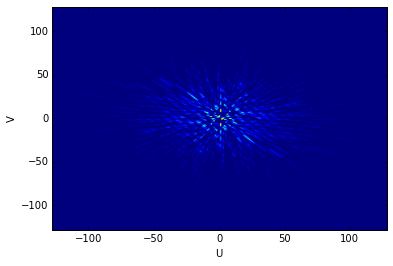

In [475]:
imshow(np.abs(gsum), aspect='auto', origin='lower', extent=extents)
xlabel('U')
ylabel('V')

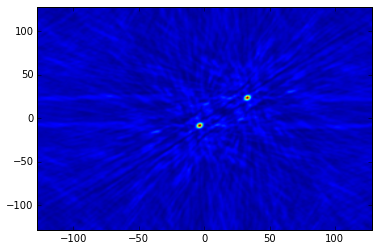

In [486]:
sumimg = image_fft(gsum)
imshow(np.real(sumimg), aspect='auto', origin='lower', extent=extents)


In [477]:
print('ABS', np.abs(sumimg).max(), 'real', np.real(sumimg).max(), 'imag', np.imag(sumimg).max())

ABS 3.740767002105713 real 3.740767002105713 imag 1.9055937383605226e-15


In [487]:
# Let's make a gridder that takes in 2 sets of UV data and does the gridding
def grid_c2r(p, uvdata1, uvdata2, lambdas, ucell, vcell, Npix, weights=False):
    ''' 
    Grids sets of data onto a single complex grid so that the FFT produces the differnt values
    in the real part and in the imaginary part.
    '''
    assert len(uvdata1) == len(uvdata2), 'UV data shapes must be equal'
    g = np.zeros((Npix, Npix), dtype=np.complex64)
    for (a1, a2) in list(uvdata1.keys()):
         # UVW im meters
        u_m = p[a1]['U (m)'] - p[a2]['U (m)']
        v_m = p[a1]['V (m)'] - p[a2]['V (m)']
        w_m = p[a1]['W (m)'] - p[a2]['W (m)']
        
        # uvw in wavelengths - these are vectors becuase lambdas is a vector
        ulam = u_m/lambdas
        vlam = v_m/lambdas
        wlam = u_m/lambdas

        # u and v coordinates in pixels. Centered on the center of the uv plane
        upix = np.round(ulam/ucell + float(Npix)/2.+0.0).astype(int) 
        vpix = np.round(vlam/vcell + float(Npix)/2.+0.0).astype(int)       

        assert np.all(upix >= 0), "invalid upix{}".format(upix)
        assert np.all(upix < Npix)
        assert np.all(vpix >=0)
        assert np.all(vpix < Npix), 'invalid vpix ibl={}{}{}'.format(a1,a2, vpix)

        # If upix or vpix contain multiple N identical indices, the it only increments by 1, not by 
        # N as expected. So we need to unroll the loop
        #g[vpix,upix] += 1

        if weights:
            for vp,up in zip(vpix, upix):
                g[vp, up] += 1
                g[-vp,-up] += 1
        else:
            for ichan, (vp, up) in enumerate(zip(vpix, upix)):
                # V1 will be Hermetian and and up in the real component
                # v2 will be anti-hermetian and end up in the imaginary component
                # We need to multiply v2 by 1j (equivalent to swapping real adn imaginary parts)
                # And changing the sign of one of them
                # Otherwise the phase is wrong
                v1 = uvdata1[(a1,a2)][ichan]
                v2 = uvdata2[(a1,a2)][ichan]*1j
                g[vp,up] += v1 + v2
                g[-vp,-up] += np.conj(v1) - np.conj(v2)

    return g

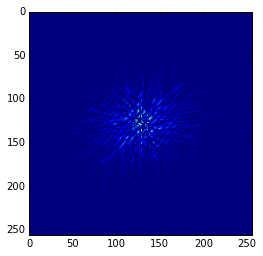

In [488]:
grid_c = grid_c2r(p, uvdata1, uvdata2, lambdas, vcell, vcell, Npix, weights=False)
imshow(np.abs(grid_c))

ABS 3.6265887953455884 real 3.605726957321167 imag 3.62473201751709


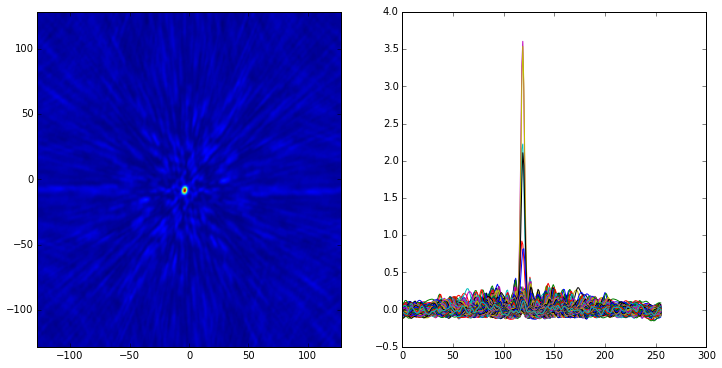

In [489]:
image_c = image_fft(grid_c)
print('ABS', np.abs(image_c).max(), 'real', np.abs(image_c.real).max(), 'imag', np.abs(image_c.imag).max())
fig, ax = subplots(1,2, figsize=(12, 6))
ax[0].imshow(np.real(image_c), aspect='auto', origin='lower', extent=extents)
_ = ax[1].plot(image_c.real)


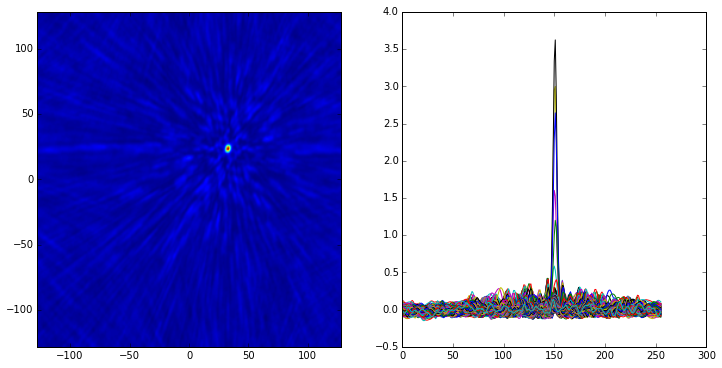

In [490]:
fig, ax = subplots(1,2, figsize=(12, 6))
ax[0].imshow(np.imag(image_c), aspect='auto', origin='lower', extent=extents)
_ = ax[1].plot(image_c.imag)

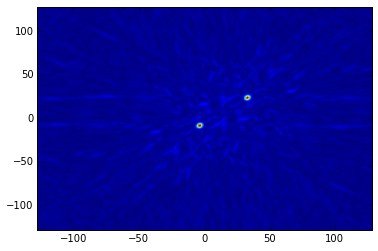

In [491]:
imshow(np.abs(image_c), aspect='auto', origin='lower', extent=extents)

# 1D test on how to load different data into real and imaginary

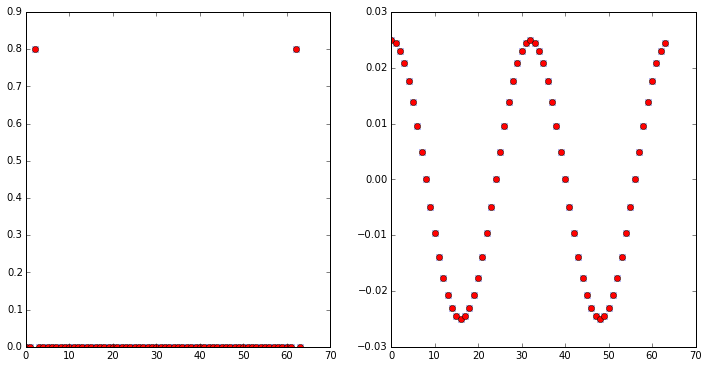

In [520]:
x = np.zeros(64, dtype=np.complex64)
i1 = 2
a1 = 0.8*np.exp(np.radians(0)*1j)


i2 = 2
a2 = 0.8*np.exp(np.radians(0)*1j)

# Grid of hte hermetian -> real part in the FFT output
x[i1] += a1
x[-i1] += np.conj(a1)


# Grid of the anti-hermtian -> imag part in the FFT output
x[i2] += times1j(a2)
x[-i2] += -np.conj(times1j(a2))


xf = np.fft.ifft(x)
fig, axs = subplots(1,2, figsize=(12,6))
axs[0].plot(x.real, 'bx')
axs[0].plot(x.imag, 'ro')
axs[1].plot(xf.real, 'bx')
axs[1].plot(xf.imag, 'ro')

def times1j(x):
    return -x.imag + 1j*x.real

In [493]:
np.exp(np.radians(90)*1j)

(6.123233995736766e-17+1j)

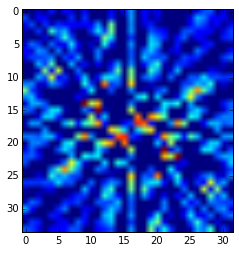

In [511]:
imshow(abs(g[126-16:128+16,128-16:128+16]))